# Preparing Data for Colab Models: title and summary scoring

Let's prepare previously parsed data. This notebook is intended for converting the dataset containing information about articles to several smaller datasets necessary for training and testing the scoring model. The goal of the project is to increase the number of views, so we use the number of views of published articles as a criterion.

In [1]:
# data processing libraries
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm 
tqdm.pandas()  # data processing progress bar

# directory where all datasets are placed
DATASETS_PATH = "/home/leo/DATASETS"

%matplotlib inline

## 1. Read Dataframe with Titles and Views Numbers

Now we have a lot of data obtained as a result of web scraping, combined into one large dataset. For reading we use `read_df()` functions and for occasional work with dataset and saving results – `write_df()`.

In [94]:
def read_df(filename = 'it_articles_ru'):
    """Read total dataframe with information about all sources"""
    df = pd.read_feather(f'{DATASETS_PATH}/{filename}.feather')
    
    # feather format doesn't work with str indices
    df = df.set_index('index')  
    
    # convinient order of columns
    df = df[['title', 'summary', 'views_num',
             'post_time', 'parse_time',
             'likes_num', 'favs_num', 'comments_num',
             'source', 'filename']]
    
    # parse timing cols ad datetime
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    # drop dupicates, keep last of all duplicate rows
    df = df.loc[~df.index.duplicated(keep='last')]
    
    # drop non-public articles
    df = df.drop(df[df.views_num == 0.0].index)
    
    return df


def write_df(df, filename = 'it_articles_ru'):
    """Write total dataframe with information about all sources"""
    df = df.reset_index() # feather format doesn't work with str indices
    
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    # for space economy let's convert types
    df.views_num = df.views_num.astype('Int32')
    for col in ('likes_num', 'favs_num', 'comments_num'):
        df[col] = df[col].astype('Int16')
    
    # zstd compression is best for our str content
    df.to_feather(f'{DATASETS_PATH}/{filename}.feather',
                  compression='zstd')
    
    # convert time to simple iso format strings
    df.post_time = df.post_time.apply(lambda x: x.isoformat().replace('+03:00', ''))
    df.parse_time = df.parse_time.apply(lambda x: x.date().isoformat())
    
    print('Main datafame is saved.')
    
df = read_df()

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261913 entries, https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/ to https://habr.com/ru/company/zfort/blog/180153/
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         261913 non-null  object        
 1   summary       261591 non-null  object        
 2   views_num     261402 non-null  Int32         
 3   post_time     261291 non-null  datetime64[ns]
 4   parse_time    261404 non-null  datetime64[ns]
 5   likes_num     217990 non-null  Int16         
 6   favs_num      217990 non-null  Int16         
 7   comments_num  255398 non-null  Int16         
 8   source        261913 non-null  object        
 9   filename      41284 non-null   object        
dtypes: Int16(3), Int32(1), datetime64[ns](2), object(4)
memory usage: 25.5+ MB


Some information about current state of the main dataframe in a report form:

In [96]:
df

,title,summary,views_num,post_time,parse_time,likes_num,favs_num,comments_num,source,filename
index,,,,,,,,,,
https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/,7 практических заданий с собеседования на пози...,Для начинающего разработчика очень важно не то...,8642,2021-03-01 09:05:11,2021-04-19,13,10,10,tproger,80f10716-5243-55ca-a67d-4dfe77cd27a5
https://tproger.ru/quiz/test-chto-mozhet-jeta-nejroset/,"Тест: что реально, а что создала нейросеть?",Сегодня нейронные сети используются в сельском...,4967,2021-02-26 19:39:50,2021-04-19,2,1,0,tproger,aaffd2c5-592f-5d7b-b972-95073d0da49a
https://tproger.ru/articles/kak-najti-dejstvitelno-horoshij-kurs-po-razrabotke-8-shagov-na-puti-k-pravilnomu-vyboru/,Как найти действительно хороший курс по разраб...,Сразу хочется пошутить и предложить разработат...,1291,2021-02-26 17:29:00,2021-04-19,1,4,1,tproger,16f80dbb-8e7c-5a5b-9025-b2fdef30bfd0
https://tproger.ru/articles/blackbox-skanery-v-processe-ocenki-bezopasnosti-prilozhenija/,Blackbox-сканеры в процессе оценки безопасност...,Профиль задач quality engineer (QE) достаточно...,233,2021-02-26 15:16:46,2021-04-19,0,1,0,tproger,9d58bde6-7aaf-57a4-b381-25171b9a368f
https://tproger.ru/articles/instrumenty-upravlenija-komandoj-razrabotki-na-udalenke-kak-ne-meshat-rabotat/,Инструменты управления командой разработки на ...,В КРОК геораспределенная структура офисов разр...,589,2021-02-25 18:56:54,2021-04-19,3,3,0,tproger,9d429725-8241-5ddf-9b08-43d3d58629ec
...,...,...,...,...,...,...,...,...,...,...
https://habr.com/ru/post/16357/,VoIP в России — Сервис FlashPhone.ru,"В начале осени я писал, про то что, Flex будет...",304,2007-11-18 18:14:00,2021-04-23,4,5,22,habr,None
https://habr.com/ru/post/180551/,Про рейтинги: Ху из ху на рынке digital-аналит...,Среди компаний веб-разработки принято мериться...,5100,2013-05-22 14:03:00,2021-04-23,-4,10,6,habr,None
https://habr.com/ru/company/microsoft/blog/180407/,Стартап-история месяца конкурса Microsoft BizS...,Теперь когда все уже вполне вернулись в строй ...,3700,2013-05-21 11:03:00,2021-04-23,0,3,3,habr,None


In [110]:
df.source.value_counts()

habr            214949
xakep            36752
dou               5680
proglib           1750
tproger           1293
tinkoff            656
thecode            509
digitalocean       324
Name: source, dtype: int64

In [112]:
pd.read_json(f'{DATASETS_PATH}/vc.json')

ValueError: Expected object or value

In [27]:
import re
import datetime

full_months = ['января', 'февраля', 'марта',
               'апреля', 'мая', 'июня',
               'июля', 'августа', 'сентября',
               'октября', 'ноября', 'декабря']

short_months = [month_name[:3] for month_name in full_months]
sm = '|'.join(short_months)


def str_to_datetime(s):
    '''Take string with date in russian and return datetime object'''
    sentence = s.strip().lower().split()
    now = datetime.datetime.now()
    try:
        year = int(re.search(r'\d{4}', s).group(0))
    except AttributeError:
        year = now.year
    try:
        month = re.search(f'{sm}', s).group(0)
        month = short_months.index(month) + 1
        day = int(
            re.search(r'(?<!\d{2})\d{1,2}(?=\s)(?! дня|\d+ |:\d{2})', s).group(0))
    except AttributeError:
        if re.match(r'вчера', s):
            yesterday = (now - datetime.timedelta(days=1))
            month = yesterday.month
            day = yesterday.day
        elif re.match(r'позавчера', s):
            yesterday2 = (now - datetime.timedelta(days=2))
            month = yesterday2.month
            day = yesterday2.day
        elif re.match(r'завтра', s):
            tomorrow = (now - datetime.timedelta(days=2))
            month = tomorrow.month
            day = tomorrow.day
        else:
            month = now.month
            day = now.day
    try:
        hour = int(re.search(r'\d{2}(?=:\d{2})', s).group(0))
        minute = int(re.search(r'(?<=\d{2}:)\d{2}', s).group(0))
    except AttributeError:
        if re.match(r'^\d+(?= мин)', s):
            t = now - \
                datetime.timedelta(minutes=int(
                    re.match(r'\d+(?= мин)', s).group(0)))
        elif re.match(r'^\d+(?= час)', s):
            t = now - \
                datetime.timedelta(
                    hours=int(re.match(r'\d+(?= час)', s).group(0)))
        else:
            t = now
        hour = t.hour
        minute = t.minute
    return datetime.datetime(year,
                             month,
                             day,
                             hour,
                             minute)

In [79]:
def habr_prepare(path=f'{DATASETS_PATH}/habr.json'):
    #df_habr['filename'] = df['url'].apply(lambda x: str(uuid.uuid5(uuid.NAMESPACE_DNS, x)))
    df_habr = pd.read_json(path).set_index('url')
    df_habr = df_habr[~df_habr.index.duplicated(keep='first')]
    df_habr.post_time = df_habr.post_time.apply(str_to_datetime)
    df_habr.post_time = pd.to_datetime(df_habr.post_time)
    df_habr.parse_time = pd.to_datetime('today')
    df_habr['parse_time'] = pd.to_datetime(datetime.date.today())
    df_habr.likes_num = df_habr.likes_num.apply(lambda x: x.replace('–', '-')).apply(int)
    df_habr.views_num = df_habr.views_num.apply(lambda x: x.replace(',', '.').replace('k', 'e+3')).apply(float).apply(int)
    df_habr.comments_num = df_habr.comments_num.fillna(0).apply(int)
    df_habr.summary = df_habr.summary.apply(lambda x: re.sub(r'[\n\r\s]{2,}', '\n', x.replace('Читать дальше →', '').strip()))
    df_habr['source'] = 'habr'
    return df_habr

df_habr = habr_prepare()

,title,post_time,comments_num,views_num,short_text,source
index,,,,,,
https://vc.ru/28258,Как заработать на статистических исследованиях...,31 окт 2017,57,7197,NaN,vc
https://vc.ru/28386,Два раза в одну реку: зачем и как нанимать быв...,2 ноя 2017,9,8797,NaN,vc
https://vc.ru/28123,Оператор МТС запустил приложение для заказа та...,27 окт 2017,35,7253,NaN,vc
https://vc.ru/28991,Путеводитель по игровому PR,13 ноя 2017,2,2671,NaN,vc
https://vc.ru/28235,Как мы за два дня разработали приложение для н...,31 окт 2017,20,6778,NaN,vc
...,...,...,...,...,...,...
https://vc.ru/7915,«Партия еды» — сервис доставки продуктов для у...,24 апр 2015,67,8911,"Сегодня за «Трибуной» — сервис «Партия еды», к...",vc
https://vc.ru/7676,Гендиректор Mobio Алексей Писаревский об устро...,13 апр 2015,17,7188,Генеральный директор мобильного агентства Mobi...,vc
https://vc.ru/7352,«Манго Телеком» угрожает судом конкуренту amoC...,23 мар 2015,46,11 893,"Компания «Манго Телеком», разработавшая систем...",vc


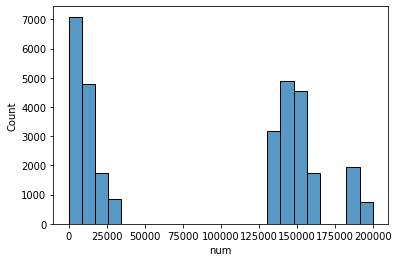

In [27]:
import datetime
import dask.dataframe as dd
import re

def read_vc():
    d = dd.read_csv(f'{DATASETS_PATH}/vcru*.csv', dtype={'comments_num': 'object'}).compute()
    d = d.drop(columns='web-scraper-order')
    d = d.rename(columns={'web-scraper-start-url':'index'}).set_index('index')
    #d.views_num = d.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))
    d = d.drop_duplicates(keep='last')
    months = ['янв', 'фев', 'мар', 'апр', 'мая', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
    #d['post_time'] = pd.to_datetime(d['post_time'].apply(lambda x: x.split()[2] + '-' + str(months.index(x.split()[1])+1)+ '-' + x.split()[0]))
    #d['parse_time'] = pd.to_datetime('today').date()
    d['source'] = 'vc'
    d['num'] = d.index.map(lambda x: int(x.split('/')[-1]))
    sns.histplot(d.num)
    d = d.drop(columns='num')
    return d

d = read_vc()
d

## 2. ML Correction of Underestimated Number of Views
The number of views on sites sometimes significantly lags behind the expected or is not always calculated correctly. For example, for new articles, or articles that changed the publicity status. This is especially noticeable when the number of views is less than the number of likes and bookmarks. To correct such values, we build a simple SGD regression model on data we can trust. Next, we extrapolate the result to "suspicious" data.

- В обучении нужно учитывать ресурс - для разных источников разная склонность к 
- Вместо разницы с текущем временем корректнее использовать дату парсинга

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

df['post_time'] = pd.to_datetime(df['post_time'], utc=True)
df['mln_secs_to_now'] = (pd.Timestamp.now(tz='UTC') - df['post_time']).apply(lambda x: x.total_seconds())*1e-6
df_tmp = df[['likes_num', 'favs_num', 'comments_num', 'views_num']].dropna()
df_tmp['suspicious'] = [False]*df_tmp.shape[0]
for col in ('likes', 'favs', 'comments'):
    df_tmp['suspicious'] += df_tmp[f'{col}_num'] > 0.1*df_tmp['views_num']

df_tmp_susp = df_tmp[df_tmp['suspicious'] == True]
df_tmp = df_tmp[df_tmp['suspicious'] == False]
df_tmp = df_tmp.drop(columns=['suspicious'])
df_tmp_susp = df_tmp_susp.drop(columns=['suspicious'])

y = df_tmp['views_num']
X = df_tmp.drop(columns=['views_num'])
reg = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_jobs=20))
reg.fit(X, y)
df_tmp_susp['views_num'] = reg.predict(df_tmp_susp.drop(columns=['views_num']))
df_tmp_susp['views_num'] = df_tmp_susp['views_num'].apply(round)
df_tmp = pd.concat([df_tmp, df_tmp_susp])
df.update(df_tmp)

## 3. Target Variable Conversion: Views to Rating

Let's create datasets with the minimum required set of columns, corresponding to the model. We will intentionally code both the title and the summary together, since this is exactly the information that the user sees.

Now we will sort the articles by the number of views and set each position in the top 20% to 1, and for the rest – 0. So the closer the classification score to 1, the more likely the article will receive more views.

In [109]:
Xy = df[['title', 'views_num']]
Xy['title'] = Xy['title'].apply(str)
#max_title_length = Xy.title.apply(len).max()
Xy.sort_values(by='views_num', inplace=True)

bound = round(Xy.shape[0]*0.2)
Xy['score'] = 0
Xy.score.iloc[-bound:] = 1
Xy['score'] = Xy['score'].astype('int8')
Xy.drop(columns='views_num', inplace=True)

In [110]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229192 entries, https://habr.com/ru/post/81826 to https://habr.com/ru/post/491974
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   229192 non-null  object
 1   score   229192 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 3.7+ MB


In [112]:
Xy.to_pickle('Xy.pickle', compression='gzip', protocol=4)

# XXX Archive & Drafts XXX

In [ ]:
# import uuid
# df['filename'] = pd.Series(df.index).apply(lambda x: str(uuid.uuid5(uuid.NAMESPACE_DNS, x)))

# def save_new_data(filename, source, full_text):
#     '''Сохраняет новые данные в датафрейм, а текст -- в отдельный файл'''
#     filepath = f"{DATASETS_PATH}/{source}/{filename}"
#     if not os.path.exists(filepath):
#         with open(filepath, 'w') as f:
#             full_text = re.sub('\n+', '\n\n', full_text).strip()
#             f.write(full_text)
#     else:
#         pass

# def filter_df(df):
#     # drop all non-digit symbols in views of num
#     df.views_num = df.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))


# import datetime

# df_tmp = pd.read_csv(f'{DATASETS_PATH}/xakep.csv')
# df_tmp = df_tmp.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
# df_tmp = df_tmp.set_index('title-href')
# #df_tmp = df_tmp.fillna(0)

# def find_digit(s):
#     digit_string = re.findall(r'\d+', s)
#     if digit_string:
#         return int(digit_string[0])
#     else:
#         return 0

# df_tmp.comments_num = df_tmp.comments_num.apply(find_digit)
# df_tmp['parse_time'] = datetime.datetime.now()
# df_tmp['comments_num'] = df_tmp['comments_num'].replace('Обсудить', '0')
# df_tmp['comments_num'] = df_tmp['comments_num'].astype('int8')
# df_tmp['likes_num'] = df_tmp['likes_num'].astype('int8')
# df_tmp['favs_num'] = df_tmp['favs_num'].astype('int8')
# df_tmp.set_index('url-href').to_csv(f'{DATASETS_PATH}/thecode.csv')

# def filename(x):
#     return str(uuid.uuid5(uuid.NAMESPACE_DNS, x))